## Reduced rank regression para video denoising

Resumidamente, a ideia de reduced rank regression é, dada uma matriz de dados $Y$
e uma matriz de preditores $X$, encontrar $B$ de dimensão reduzida tal que
$$Y = XB + E,$$
onde $E$ é uma matriz de erros.

Para video denoising, esperamos portanto reconstruir $Y$ sem ruído com $Y = XB$, afinal os ruídos ficariam concentrados em $E$.

"Statistical Learning with Sparsity" sugere a formulação do problema
de forma que $Y$ contenha os frames do vídeo (cada coluna é um frame *flattened*)
e $X$ seja uma coleção de funções de base para imagem.

O livro exemplifica $X$ com uma união de bases ortonormais.

In [1]:
import numpy as np
import cv2
from scipy.fftpack import dct
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt

def plot_frame(frame, title):
    plt.figure()
    plt.imshow(frame, cmap='gray')
    plt.title(title)
    # remove ticks
    plt.xticks([])
    plt.yticks([])
    plt.show()

Montando $Y$:

(102240, 120)


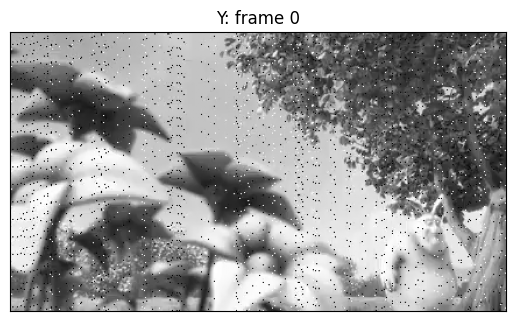

In [ ]:
vid = cv2.VideoCapture('in/video_noisy.mp4')
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if ret:
        # Convert to grayscale and flatten
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame_gray.flatten())
    else:
        break
vid.release()
frames = np.array(frames)
Y = frames.T
print(Y.shape)
plot_frame(Y[:, 0].reshape(240, 426), 'Y[:, 0]')

In [4]:
'''X = np.zeros(Y.shape)
for i in range(Y.shape[1]):
    X[:, i] = cv2.medianBlur(Y[:, i].reshape(240, 426).astype(np.uint8), 3).flatten()   
print(X.shape)
plot_frame(X[:, 0].reshape(240, 426), 'X: frame 0')'''

"X = np.zeros(Y.shape)\nfor i in range(Y.shape[1]):\n    X[:, i] = cv2.medianBlur(Y[:, i].reshape(240, 426).astype(np.uint8), 3).flatten()   \nprint(X.shape)\nplot_frame(X[:, 0].reshape(240, 426), 'X: frame 0')"

In [5]:
def create_dct_basis(n, c):
    return dct(np.eye(n, c), norm='ortho', axis=0)

Montando $X$. 
Minha tentativa será apenas com uma base ortonormal construída a partir da aplicação do PCA,
pois tentativas com DCT e Wavelet (essa última sugerida pelo livro) não pareceram ajudar.

In [6]:
#dct_basis = create_dct_basis(Y.shape[0], 30)

pca = PCA(n_components=30)
pca_basis = pca.fit(Y.T).components_.T

#wavelet_basis = pywt.wavedec(np.eye(Y.shape[0], 30), 'haar', level=2, axis=0)
#wavelet_basis = np.vstack(wavelet_basis)
#wavelet_basis.shape

In [7]:
def is_orthonormal(matrix, tol=1e-9):
    gram_matrix = matrix.T @ matrix
    identity = np.eye(gram_matrix.shape[0])
    return np.allclose(gram_matrix, identity, atol=tol)

In [8]:
is_orthonormal(pca_basis)

True

In [9]:
X = np.hstack([
    pca_basis
])
X.shape

(102240, 30)

Usando a ideia mais básica [deste artigo](https://dept.stat.lsa.umich.edu/~jizhu/pubs/Mukherjee-SADM11.pdf) e no livro, resolveremos a otimização usando mímimos quadrados ordinários e SVD.

In [20]:
B_ols = np.linalg.lstsq(X, Y, rcond=None)[0]
B_ols.shape

(30, 120)

In [37]:
r = 10

In [44]:
U, s, Vt = np.linalg.svd(X @ B_ols, full_matrices=False)
# truncando
Vr = Vt[:r, :].T
Ur = U[:, :r]
print(Vr.shape)

(120, 10)


In [46]:
B_rrr = B_ols @ Vr @ Vr.T
B_rrr.shape

(30, 120)

In [47]:
Yr = X @ B_rrr

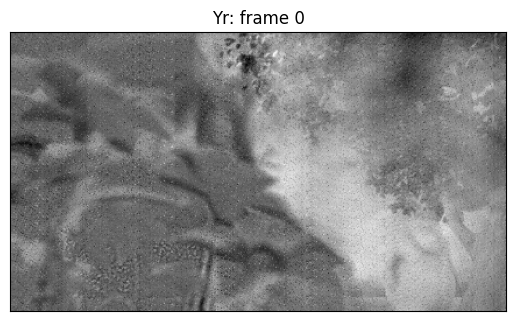

In [48]:
plot_frame(Yr[:, 0].reshape(240, 426), 'Yr: frame 0')

O resultado não ficou bom...

Acredito que a regressão linear simples não foi capaz de lidar com o ruído pesado do vídeo,
pois o vídeo é bem comportado (poucas mudanças entre os quadros).

Uma ideia natural seria tentar outro tipo de otimização.

In [49]:
# salvando o resultado
Y_out = Yr.T.reshape(-1, 240, 426)
frames_normalized = []
for i, frame in enumerate(Y_out):
    frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    frames_normalized.append(frame_normalized)
# write video
out = cv2.VideoWriter('out/video_reconstructed_lstsq.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (426, 240))
for frame in frames_normalized:
    out.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))
out.release()

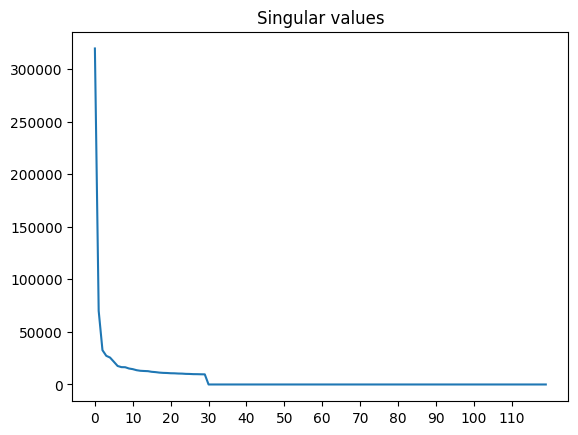

In [50]:
# plot s
plt.plot(s)
plt.title('Singular values')
# add more ticks
plt.xticks(range(0, len(s), 10))
plt.show()